In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import MDS 
import glob
import math
import re
import sys
sys.path.append('..')
from Clustering_Functions import *
from itertools import combinations
import itertools
import os
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
def Borda_vector(ballot, num_cands , borda_style='pes', start = 0):
    """
    Returns the Borda vector of the given (simple or generalized) ballot.
        
    Args:
        ballot : a simple or generalized ballot (tuple of integers or of sets of integers). 
        num_cands : the number of candidates. 
        borda_style : choice of {'pes', 'avg'}
        start : the lowest score awarded; for example, set start=1 if you want a full ballot to award {1,2,...,num_cands} points.
     
    Returns:
        the Borda vector (np.array) of the given generalized ballot.                
    """

    # append set of missing candidates to end of ballot
    ballot = list(ballot)
    missing_cands = set(range(1,num_cands+1))
    for c in ballot:
        S = c if type(c) == set else {c}
        for x in S:
            missing_cands.discard(x)
    if len(missing_cands) > 0:
        ballot.append(missing_cands)
    # compute Borda vector
    score_queue = list(range(start, start+num_cands))
    to_return = [0 for _ in range(num_cands)]
    for c in ballot:
        S = c if type(c) == set else {c}
        scores = [score_queue.pop() for _ in range(len(S))]
        points = np.mean(scores) if borda_style == 'avg' else min(scores)
        for x in S:
            to_return[x-1] = points

    return np.array(to_return)

In [3]:
def Reverse_Borda(proxy):
    """ 
    Returns the generalized ballot corresponding to the given Borda proxy vector.
    Returns a simple ballot if possible, otherwise a generalized ballot
    Works with any borda_style convention ('pes' or 'avg') 
    """
    num_cands = len(proxy)

    proxy = list(proxy)
    to_return = []
    cands_placed = []
    while len(cands_placed) < num_cands:
        S = [x for x in range(1,num_cands+1) if proxy[x-1]==np.max(proxy)] # best-scoring candidates
        cands_placed.extend(S)
        to_return.append(set(S))
        for x in S:
            proxy[x-1] = -1

    # return a simple ballot if possible
    if all(len(c)==1 for c in to_return[:-1]):
        return tuple([list(c)[0] for c in to_return if len(c)==1])
    else:
        return tuple(to_return)

In [4]:
def HH_proxy(ballot,num_cands):
    """
    Returns the head-to-head proxy vector of the given (simple or generalized) ballot.
        
    This is a vector with one entry for each pair of candidates ordered in the natural way; namely {(1,2),(1,3),...,(1,n),(2,3),...}. 
    The entries lie in {-1,0,1} depending on whether the lower-indexed candidate {looses, ties, wins} the head-to-head comparison. 

    Args:
        ballot: a simple or generalized ballot (tuple of integers or of sets of integers).
    
    Returns:
        The head-to-head proxy vector (np.array)
    """
    # append set of missing candidates to end of ballot
    ballot = list(ballot)
    missing_cands = set(range(1,num_cands+1))
    for c in ballot:
        S = c if type(c) == set else {c}
        for x in S:
            missing_cands.discard(x)
    if len(missing_cands) > 0:
        ballot.append(missing_cands)

    M = np.full([num_cands,num_cands], np.nan)

    # first place the zeros for ties and build the unpacked ballot
    unpacked_ballot = []
    for c in ballot:
        S = c if type(c) == set else {c}
        if len(S)>1:
            for x,y in combinations(S,2):
                M[x-1,y-1] = 0
                M[y-1,x-1] = 0
        unpacked_ballot.extend(S)

    # now place the -1 and 1 entries
    for x,y in combinations(unpacked_ballot,2):
        if M[x-1,y-1] != 0:
            M[x-1,y-1] = 1
            M[y-1,x-1] = -1

    # flatten the matrix into a vector
    to_return = []
    for x,y in combinations(range(num_cands),2):
        to_return.append(M[x,y])
    return np.array(to_return)

In [5]:
def Reverse_HH(proxy):
    """ 
    Returns the (simple or generalized) ballot corresponding to the given HH proxy vector,
    or None if the proxy is inconsistent.
    Any positive entry (not just +1) is interpreted as a win for the lower-indexed candidate, and any negative entry a loss,
    while a zero entry indicates a tie.
    Returns a simple ballot if possible, otherwise a generalized ballot.
    """
    # determine the number of candidates
    proxy = list(proxy)
    A = np.sqrt(1+8*len(proxy))
    if not A.is_integer():
        raise ValueError("Invalid proxy vector")
    num_cands = int((1+A)/2)
    
    cand_pairs = list(combinations(range(1,num_cands+1),2))
    ballot = [{num_cands}] # initialize ballot: bullet vote for last candidate

    # We'll work through cand_pairs (i,j) in reverse order.  
    # For 5 candidates, the order is (4,5) | (3,5), (3,4) | (2,5), (2,4), (2,3) | (1,5), (1,4), (1,3), (1,2)
    # which breaks into groups for i = 4,3,2,1
    # for each group, we add i to the top of the ballot, and then use the rest of the group's information to reposition i correctly
    # (or return None if the rest of the group has inconsisent information).
    for i in range(num_cands-1,0,-1):
        group_indices = [x for x in range(len(cand_pairs)) if cand_pairs[x][0]==i]
        left_of_i = [cand_pairs[x][1] for x in group_indices if proxy[x]<0]
        right_of_i = [cand_pairs[x][1] for x in group_indices if proxy[x]>0]
        match_i = [cand_pairs[x][1] for x in group_indices if proxy[x] == 0]
        ballot_map = [] # has one entry {-1,0,+1} for each set in the ballot, indicating whether the set should be left, right, or containing i.
        for c in ballot:
            S = c if type(c) == set else {c}
            if all(x in left_of_i for x in S):
                ballot_map.append(-1)
            elif all(x in right_of_i for x in S):
                ballot_map.append(1)
            elif all(x in match_i for x in S):
                ballot_map.append(0)
            else:
                return None # inconsistent proxy
            
        zero_indices = [x for x in range(len(ballot_map)) if ballot_map[x]==0]
        if (ballot_map != sorted(ballot_map)) or (len(zero_indices)>1):
            return None # inconsistent proxy
        
        if len(zero_indices)==0:
            insertion_index = len(ballot_map) if all(val <= 0 for val in ballot_map) else min([x for x in range(len(ballot_map)) if ballot_map[x] >=0])
            ballot.insert(insertion_index,{i})
            #print(f'inserting {i} at {insertion_index} to get {ballot}')    
        else:
            insertion_index = zero_indices[0]
            ballot[insertion_index] = ballot[insertion_index].union({i})
            #print(f'adding {i} to {insertion_index} to get {ballot}')
    # return a simple ballot if possible
    if all(len(c)==1 for c in ballot[:-1]):
        return tuple([list(c)[0] for c in ballot if len(c)==1])
    else:
        return tuple(ballot)

In [12]:
b = (4, {2,3}, 1, {5,6,7})
p = HH_proxy(b,10)
print(Reverse_HH(HH_proxy(b,10)))
print(Reverse_Borda(Borda_vector(b,10)))

({4}, {2, 3}, {1}, {5, 6, 7}, {8, 9, 10})
({4}, {2, 3}, {1}, {5, 6, 7}, {8, 9, 10})


In [13]:
b = (4, 6, 3)
p = HH_proxy(b,10)
print(Reverse_HH(HH_proxy(b,10)))
print(Reverse_Borda(Borda_vector(b,10)))

(4, 6, 3)
(4, 6, 3)


In [9]:
filepath = '../ballot-clustering old versions'
dfK = pd.read_pickle(f'{filepath}/results_2025.pkl') # heuristic results
dfIP = pd.read_pickle(f'{filepath}/IP_results_v2.pkl') # IP results

In [10]:
# create `df` dataframe to hold IP and heuristic results.
d_proxy = {'bordaa': 'BA', 'bordap': 'BP', 'hh': 'HH'}
df = pd.DataFrame(columns=['filename', 'num_cands', 'method', 'proxy_type', 'technique', 
                           'centers', 'proxies_of_centers', 'center_proxy_match_good','clustering'])

# Add the IP results to the dataframe

for index in dfIP.index:
    filename = f"{dfIP['election'][index]}.csv" 
    num_cands = dfIP['num_candidates'][index]
        
    proxies_of_centers = dfIP['centroids'][index]
    clustering = dfIP['ballots'][index]
    method = dfIP['method'][index]
    proxy_type = d_proxy[dfIP['proxy'][index]]
    technique = f"{method}_{proxy_type}"

    if proxy_type == 'HH':
        centers = {i: Reverse_HH(proxy) for i, proxy in proxies_of_centers.items()}
        center_proxy_match = all(centers[i] is not None for i in centers)
    else:
        centers = {i: Reverse_Borda(proxy) for i, proxy in proxies_of_centers.items()}
        borda_style = 'pes' if proxy_type == 'BP' else 'avg'
        center_proxy_match = all(all(Borda_vector(centers[i],num_cands, borda_style) == np.array(proxy)) for i, proxy in proxies_of_centers.items())

    t = df.shape[0]
    df.loc[t] = [filename, num_cands, method, proxy_type, technique,
                  centers, proxies_of_centers, center_proxy_match, clustering]

In [11]:
# add the heuristic results to the dataframe

D = {'meanBA': ('Lloyd', 'BA'), 'meanBC': ('Lloyd', 'BP'), 'meanH': ('Lloyd', 'HH'), 
     'medoBA': ('PAM', 'BA'), 'medoBC': ('PAM', 'BP'), 'medoH': ('PAM', 'HH'), 'slate': ('slate', None)}

for index in dfK.index:
    filename = dfK['filename'][index] 
    num_cands = dfK['num_cands'][index]
    clustering = dfK['clustering'][index]
    m = dfK['method'][index]
    if m == 'slate_weak':
        continue
    method, proxy_type = D[m]

    technique = method if method == 'slate' else f"{method}_{proxy_type}"

    if method == 'Lloyd':
        proxies_of_centers_as_array = dfK['centers'][index]
        proxies_of_centers = {0: proxies_of_centers_as_array[0], 1: proxies_of_centers_as_array[1]}
        if proxy_type == 'HH':
            centers = {i: Reverse_HH(proxy) for i, proxy in proxies_of_centers.items()}
            center_proxy_match = all(centers[i] is not None for i in centers)
        else:
            centers = {i: Reverse_Borda(proxy) for i, proxy in proxies_of_centers.items()}
            borda_style = 'pes' if proxy_type == 'BP' else 'avg'
            center_proxy_match = all(all(Borda_vector(centers[i],num_cands, borda_style) == np.array(proxy)) for i, proxy in proxies_of_centers.items())
    elif method == 'PAM':
        centers = dfK['centers'][index]
        if proxy_type == 'HH':
            proxies_of_centers = {i: HH_proxy(centers[i], num_cands) for i, center in centers.items()}
            center_proxy_match = True
        else:
            borda_style = 'pes' if proxy_type == 'BP' else 'avg'
            proxies_of_centers = {i: Borda_vector(center,num_cands, borda_style) for i, center in centers.items()}
            center_proxy_match = True
    else:
        centers = dfK['centers'][index]
        proxies_of_centers = None
        center_proxy_match = None
    t = df.shape[0]
    df.loc[t] = [filename, num_cands, method, proxy_type, technique, centers, proxies_of_centers, center_proxy_match, clustering]

In [12]:
# df.to_pickle(f'{filepath}/merged_data_with_generalized_ballots.pkl')

In [16]:
filepath = '../../ballot-clustering old versions'
df = pd.read_pickle(f'{filepath}/merged_data_with_generalized_ballots.pkl')

In [17]:
df.columns

Index(['filename', 'num_cands', 'method', 'proxy_type', 'technique', 'centers',
       'proxies_of_centers', 'center_proxy_match_good', 'clustering'],
      dtype='object')

In [30]:
df['technique'].unique()

array(['continuous_BA', 'continuous_BP', 'continuous_HH',
       'continuous_rest_BA', 'continuous_rest_BP', 'continuous_rest_HH',
       'discrete_BA', 'discrete_BP', 'discrete_HH', 'Lloyd_BP',
       'Lloyd_BA', 'Lloyd_HH', 'PAM_BP', 'PAM_BA', 'PAM_HH', 'slate'],
      dtype=object)

In [31]:
# create a new dataframe df2 that holds old and new data for 7-candidate elections
# and add the working results of df to it.

df2 = pd.DataFrame(columns=['filename', 'num_clusters', 'num_cands', 'method', 'proxy_type', 'technique', 'centers',
       'proxies_of_centers','clustering'])
for index in df.index:
    filename = df['filename'][index]
    num_cands = df['num_cands'][index]
    if num_cands !=7:
        continue
    num_clusters = len(df['centers'][index])
    method = df['method'][index]
    proxy_type = df['proxy_type'][index]
    technique = df['technique'][index]
    if not technique in ['continuous_BP', 'continuous_rest_BP',
       'discrete_BA', 'discrete_BP', 'discrete_HH', 'Lloyd_BP',
       'Lloyd_BA', 'Lloyd_HH', 'PAM_BP', 'PAM_BA', 'PAM_HH', 'slate']:
        continue
    centers = df['centers'][index]
    proxies_of_centers = df['proxies_of_centers'][index]
    clustering = df['clustering'][index]

    t = df2.shape[0]
    df2.loc[t] = [filename, num_clusters, num_cands, method, proxy_type, technique, centers,
                  proxies_of_centers, clustering]

In [4]:
filename_list = df2['filename'].unique()

In [ ]:
# add 3-means (Lloyd) clustering results to df2

for filename in filename_list:
    full_filename = f'../scot-elex/7_cands/{filename}'
    num_cands, election, cand_names, ward = csv_parse(full_filename)
    k = 3
    print(filename)

    C, centers = kmeans(election, k=3, proxy='Borda', borda_style='pes', return_centroids=True)
    t = df2.shape[0]
    df2.loc[t] = [filename, 3, 7, 'Lloyd', 'BP', 'Lloyd_BP',
                   {i:Reverse_Borda(centers[i]) for i in range(k)},
                   {i:centers[i] for i in range(k)},
                   {i:C[i] for i in range(k)}]
    
    C, centers = kmeans(election, k=3, proxy='HH', return_centroids=True)
    t = df2.shape[0]
    df2.loc[t] = [filename, 3, 7, 'Lloyd', 'HH', 'Lloyd_HH',
                   {i:Reverse_HH(centers[i]) for i in range(k)},
                   {i:centers[i] for i in range(k)},
                   {i:C[i] for i in range(k)}]

In [ ]:
# add 3-medoids (PAM) clustering results to df2
for filename in filename_list:
    full_filename = f'../scot-elex/7_cands/{filename}'
    num_cands, election, cand_names, ward = csv_parse(full_filename)
    k = 3
    print(filename)

    C, centers = kmedoids(election, k=3, proxy='Borda', borda_style='pes', return_medoids=True)
    t = df2.shape[0]
    df2.loc[t] = [filename, 3, 7, 'PAM', 'BP', 'PAM_BP',
                   {i:centers[i] for i in range(k)},
                   {i:Borda_vector(centers[i], num_cands) for i in range(k)},
                   {i:C[i] for i in range(k)}]
    
    C, centers = kmedoids(election, k=3, proxy='HH', return_medoids=True)
    t = df2.shape[0]
    df2.loc[t] = [filename, 3, 7, 'PAM', 'HH', 'PAM_HH',
                   {i:centers[i] for i in range(k)},
                   {i:HH_proxy(centers[i], num_cands) for i in range(k)},
                   {i:C[i] for i in range(k)}]

In [ ]:
# add modularity clustering results to df2

df3 = pd.read_pickle(f'../../ballot-clustering old versions/ballot-clustering Jan 2025 version/modularity_clusterings_plus.pkl')

for filename in filename_list:
    full_filename = f'scot-elex\\7_cands\\{filename}'
    filtered = df3[df3['filename']==full_filename]
    if len(filtered) == 0:
        print(f'none for {filename} = {full_filename}')
        continue

    row_index = filtered.index[0]
    C = df3['clustering'][row_index]
    k = df3['k'][row_index]
    t = df2.shape[0]
    df2.loc[t] = [filename, k, 7, 'modularity', None, 'modularity', None,
                  None, C]
    print(f'{filename} was added')

In [64]:
# save it.
#df2.to_pickle(f'../../ballot-clustering old versions/2_and_3_clusterings.pkl')

In [3]:
df2 = pd.read_pickle(f'../../ballot-clustering old versions/2_and_3_clusterings.pkl')

In [ ]:
# add modularity_all to df (modularity clustering with the ballot graph containing all ballots)
for filename in filename_list:
    full_filename = f'../scot-elex/7_cands/{filename}'
    num_cands, election, cand_names, ward = csv_parse(full_filename)
    print(filename)

    C = Modularity_cluster(election, num_cands=num_cands, graph = 'all_ballots')
    k = len(C)
    t = df2.shape[0]
    df2.loc[t] = [filename, k, 7, 'modularity_all', None, 'modularity_all', None, None,
                   {i:C[i] for i in range(k)}]

In [5]:
df2.columns

Index(['filename', 'num_clusters', 'num_cands', 'method', 'proxy_type',
       'technique', 'centers', 'proxies_of_centers', 'clustering'],
      dtype='object')

In [9]:
df2['technique'].unique()

array(['continuous_BP', 'continuous_rest_BP', 'discrete_BA',
       'discrete_BP', 'discrete_HH', 'Lloyd_BP', 'Lloyd_BA', 'Lloyd_HH',
       'PAM_BP', 'PAM_BA', 'PAM_HH', 'slate', 'modularity'], dtype=object)

In [11]:
# add column for Silhouette score

def compute_scores(C, election, num_cands):
    labels = []
    XH = []  # first build list of ballot proxies with repititions
    for ballot, weight in election.items():
        for _ in range(weight):
            XH.append(HH_proxy(ballot, num_cands=num_cands))
            label = 0 if ballot in C[0].keys() else 1
            labels.append(label)
    sil = silhouette_score(XH, labels, metric="manhattan")
    #cal = calinski_harabasz_score(XH, labels)
    #dav = davies_bouldin_score(XH,labels)
    return sil  #, cal, dav

filename_to_sil_2 = {}
filename_to_sil_3 = {}
scores = []
for index in df2.index:
    technique = df2['technique'][index]
    if technique != 'Lloyd_HH':
        scores.append(None)
        continue
    filename = df2['filename'][index]
    full_filename = f'../scot-elex/7_cands/{filename}'
    num_cands, election, cand_names, ward = csv_parse(full_filename)
    C = df2['clustering'][index]
    k = df2['num_clusters'][index]
    sil = compute_scores(C, election, num_cands)
    if k==2:
        filename_to_sil_2[filename] = sil
    else:
        filename_to_sil_3[filename] = sil
    scores.append(sil)

df2['silhouette'] = scores

In [13]:
sils = pd.DataFrame(columns = ['filename', 'sil2', 'sil3'])
for filename in filename_to_sil_2.keys():
    sils.loc[len(sils)] = [filename, filename_to_sil_2[filename], filename_to_sil_3[filename]]

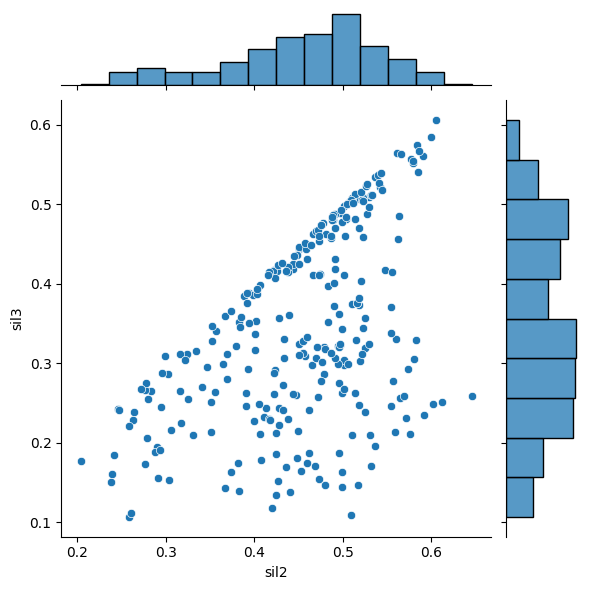

In [16]:
sns.jointplot(data=sils, x='sil2', y='sil3')

In [17]:
# Calculate the bottom quartile threshold for 'sil2' and 'sil3'
sil2_threshold = sils['sil2'].quantile(0.25)
sil3_threshold = sils['sil3'].quantile(0.25)

# Filter the dataframe to get rows where both 'sil2' and 'sil3' are in their bottom quartile
bottom_quartile_sils = sils[(sils['sil2'] <= sil2_threshold) & (sils['sil3'] <= sil3_threshold)]

# Create a list of the 'filename' entries
bottom_quartile_filenames = bottom_quartile_sils['filename'].tolist()
print(bottom_quartile_filenames)

['aberdeen_2012_ward9.csv', 'argyll_bute_2012_ward1.csv', 'argyll_bute_2012_ward2.csv', 'argyll_bute_2012_ward9.csv', 'argyll_bute_2017_ward8.csv', 'argyll_bute_2017_ward9.csv', 'eilean_siar_2012_ward5.csv', 'eilean_siar_2022_ward10.csv', 'highland_2012_ward11.csv', 'highland_2012_ward16.csv', 'highland_2012_ward2.csv', 'highland_2012_ward5.csv', 'highland_2012_ward6.csv', 'highland_2017_ward11.csv', 'highland_2022_aird_and_loch_ness.csv', 'highland_2022_inverness_south.csv', 'inverclyde_2012_ward5.csv', 'inverclyde_2017_ward5.csv', 'inverclyde_2022_ward5.csv', 'moray_2017_ward5.csv', 'orkney_2012_ward3.csv', 'orkney_2012_ward5.csv', 'orkney_2017_ward2.csv', 'orkney_2017_ward4.csv', 'sc_borders_2012_ward10.csv', 'shetland_2012_ward2.csv', 'shetland_2012_ward3.csv', 'shetland_2012_ward7.csv', 'shetland_2022_ward6.csv']


In [19]:
not_very_polarized = bottom_quartile_filenames[:20]

In [27]:
sil2_threshold = sils['sil2'].quantile(0.75)
sil3_threshold = sils['sil3'].quantile(0.5)

filtered = sils[(sils['sil2'] >= sil2_threshold) & (sils['sil3'] <= sil3_threshold)]

# Create a list of the 'filename' entries
good_for_2clustering = filtered['filename'].tolist()
len(good_for_2clustering)
good_for_2clustering = good_for_2clustering[:20]

In [28]:
filtered = sils[(sils['sil2'] <= sils['sil2'].quantile(0.6)) & (sils['sil3'] >= sils['sil3'].quantile(0.75))]

# Create a list of the 'filename' entries
good_for_3clustering = filtered['filename'].tolist()
len(good_for_3clustering)
good_for_3clustering = good_for_3clustering[:20]

In [29]:
print(not_very_polarized)
print(good_for_2clustering)
print(good_for_3clustering)

['aberdeen_2012_ward9.csv', 'argyll_bute_2012_ward1.csv', 'argyll_bute_2012_ward2.csv', 'argyll_bute_2012_ward9.csv', 'argyll_bute_2017_ward8.csv', 'argyll_bute_2017_ward9.csv', 'eilean_siar_2012_ward5.csv', 'eilean_siar_2022_ward10.csv', 'highland_2012_ward11.csv', 'highland_2012_ward16.csv', 'highland_2012_ward2.csv', 'highland_2012_ward5.csv', 'highland_2012_ward6.csv', 'highland_2017_ward11.csv', 'highland_2022_aird_and_loch_ness.csv', 'highland_2022_inverness_south.csv', 'inverclyde_2012_ward5.csv', 'inverclyde_2017_ward5.csv', 'inverclyde_2022_ward5.csv', 'moray_2017_ward5.csv']
['clackmannanshire_2012_ward1.csv', 'clackmannanshire_2022_ward1.csv', 'falkirk_2022_ward8.csv', 'fife_2012_ward16.csv', 'fife_2017_ward17.csv', 'fife_2017_ward19.csv', 'fife_2017_ward8.csv', 'north_ayrshire_2017_ward1.csv', 'north_ayrshire_2017_ward10.csv', 'north_ayrshire_2022_irvine_east.csv', 'north_lanarkshire_2012_ward7.csv', 'perth_kinross_2017_ward2.csv', 'perth_kinross_2017_ward5.csv', 'sc_border

In [40]:
# number of elections in which the Lloyd_BP and Lloyd_HH centers (agree, disagree, have inconsistent HH centers)
good_count, bad_count, inconsistent_count

(1038, 0, 32)

32/1038

In [63]:
def same_gen_ballots(b1,b2):
    """
    Returns True if the two generalized ballots are the same, False otherwise.
    """
    b1 = list(b1)
    b2 = list(b2)
    if len(b1) != len(b2):
        return False
    for i in range(len(b1)):
        S1 = b1[i] if type(b1[i]) == set else {b1[i]}
        S2 = b2[i] if type(b2[i]) == set else {b2[i]}
        if S1 != S2:
            return False
    return True

In [67]:
# Re-do the above calculation for the clustering that places all ballots into a single cluster.
# That is, determine the portion of elections for which the Lloyd_BP and Lloyd_HH centers of the WHOLE ELECTION
# (agree, disagree, have inconsisetent HH centers)

# We also count up the times that the Lloyd_BP and Lloyd_HH centers include ties.

good_count = 0
bad_count = 0
inconsistent_count = 0

BP_ties = 0
HH_ties = 0

full_filename_list = glob.glob("scot-elex/**/*.csv")
for full_filename in full_filename_list:
    filename = os.path.basename(full_filename)
    num_cands, election, cand_names, location = csv_parse(full_filename)
    BP_center_proxy, _ = Centroid_and_Medoid(election, num_cands, proxy = 'Borda', borda_style='pes', metric = 'Euclidean')
    HH_center_proxy, _ = Centroid_and_Medoid(election, num_cands, proxy = 'HH', metric = 'Euclidean')
    BP_center = Reverse_Borda(BP_center_proxy)
    HH_center = Reverse_HH(HH_center_proxy)
    #print(full_filename)
    if HH_center == None:
        inconsistent_count += 1
    elif same_gen_ballots(BP_center, HH_center):
        good_count += 1
    else:
        bad_count += 1
    if type(BP_center[0])==set:
        BP_ties += 1
    if HH_center != None and type(HH_center[0])==set:
        HH_ties += 1

In [68]:
good_count, bad_count, inconsistent_count

(540, 487, 43)

In [69]:
BP_ties, HH_ties

(0, 2)

In [38]:
v1 = [ 1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0., -1.,  0.,  1.]
v2 =  [ 0., -1., -1., -1.,  0., -1., -1.,  0., -1.,  0., -1.,  1.,  1.,
         1.,  1., -1.,  1.,  0.,  1.,  1., -1.]

In [39]:
Reverse_HH(v1), Reverse_HH(v2)

((1, 6), None)

In [41]:
print(v2)

[0.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, 0.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 0.0, 1.0, 1.0, -1.0]


In [7]:
# study Pentland Hills centers
filepath = '..'
df = pd.read_pickle(f'{filepath}/results.pkl')

In [8]:
filename = 'edinburgh_2017_ward2.csv'
dfPH = df[df['filename'] == filename].copy()

In [10]:
len(dfPH)

16

In [11]:
# print Pentland Hills centers
center_dict = {}
for index in dfPH.index:
    technique = dfPH['technique'][index]
    method = dfPH['method'][index]
    proxy_type = dfPH['proxy'][index]
    if method == 'continuous_rest':
        continue
    centers = dfPH['centers'][index]
    if method == 'continuous':
        center_dict[proxy_type] = centers

    print(f"{technique}: {centers[0]}, {centers[1]}")

continuous_BA: (1, 6), (3, 5, 7, 2)
continuous_BP: (1,), (3, 5, 7)
continuous_HH: (1, 6), (3, 5)
discrete_BA: (1, 6), (3, 5, 7)
discrete_BP: (1, 6), (3, 5, 7, 4)
discrete_HH: (1, 6), (3, 5, 4)
Lloyd_BP: (1, 6, 4, 2, 7, 3), (3, 5, 4, 7, 2, 1)
Lloyd_BA: (3, 5, 4, 7, 2, 1), (1, 6, 4, 2, 7, 3)
Lloyd_HH: (3, 5, 4, 7, 2, 1, 6), (1, 6, 4, 2, 7, 3, 5)
PAM_BP: (3, 5, 7, 4), (1, 6)
PAM_BA: (3, 5, 7), (1, 6)
PAM_HH: (1, 6), (3, 5, 4)
slate: (1, 6), (2, 3, 4, 5, 7)


In [12]:
# print proxies of centers
proxy_dict = {}
for index in dfPH.index:
    technique = dfPH['technique'][index]
    method = dfPH['method'][index]
    proxy_type = dfPH['proxy'][index]
    centers = dfPH['centers'][index]
    proxies = dfPH['proxies_of_centers'][index]
    proxy = dfPH['proxy'][index]
    method = dfPH['method'][index]
    if method == 'continuous':
        proxy_dict[proxy_type] = proxies 
    if method in ['Lloyd', 'slate'] or proxies == None:
        continue
    print(f"{technique}: {proxies[0]}, {proxies[1]}")

continuous_BA: (5.0, 2.0, 2.0, 2.5, 2.0, 5.0, 2.0), (1.5, 2.0, 6.0, 2.0, 5.0, 1.5, 3.0)
continuous_BP: (5.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0), (0.0, 0.0, 5.0, 2.0, 5.0, 0.0, 4.0)
continuous_HH: (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, -1.0, 0.0, 1.0), (0.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, 0.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 0.0, 1.0, 1.0, -1.0)
continuous_rest_BA: (6.0, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5), (2.5, 2.5, 6.0, 2.5, 2.5, 2.5, 2.5)
continuous_rest_BP: (6.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0), (0.0, 0.0, 6.0, 3.0, 5.0, 0.0, 4.0)
continuous_rest_HH: (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0), (-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0)
discrete_BA: (6.0, 2.0, 2.0, 2.0, 2.0, 5.0, 2.0), (1.5, 1.5, 6.0, 1.5, 5.0, 1.5, 4.0)
discrete_BP: (6, 0, 0, 0, 0, 5, 0), (0, 0, 6, 3, 5, 0, 4)

In [26]:
v0 = proxy_dict['BA'][0]
print(v0)
b0 = Reverse_Borda(v0)
print(b0)
v0_ = Borda_vector(b0,num_cands= 7, borda_style= 'avg')
print(v0_)

(5.0, 2.0, 2.0, 2.5, 2.0, 5.0, 2.0)
({1, 6}, {4}, {2, 3, 5, 7})
[5.5 1.5 1.5 4.  1.5 5.5 1.5]


In [28]:
v1 = proxy_dict['BA'][1]
print(v1)
b1 = Reverse_Borda(v1)
print(b1)
v1_ = Borda_vector(b1,num_cands= 7, borda_style= 'avg')
print(v1_)

(1.5, 2.0, 6.0, 2.0, 5.0, 1.5, 3.0)
({3}, {5}, {7}, {2, 4}, {1, 6})
[0.5 2.5 6.  2.5 5.  0.5 4. ]


In [29]:
v0 = proxy_dict['BP'][0]
print(v0)
b0 = Reverse_Borda(v0)
print(b0)
v0_ = Borda_vector(b0,num_cands= 7, borda_style= 'pes')
print(v0_)

(5.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0)
({1, 6}, {2, 3, 4, 5, 7})
[5 0 0 0 0 5 0]


In [30]:
v1 = proxy_dict['BP'][1]
print(v1)
b1 = Reverse_Borda(v1)
print(b1)
v1_ = Borda_vector(b1,num_cands= 7, borda_style= 'pes')
print(v1_)

(0.0, 0.0, 5.0, 2.0, 5.0, 0.0, 4.0)
({3, 5}, {7}, {4}, {1, 2, 6})
[0 0 5 3 5 0 4]
